In [4]:
import os
import sys

root_dir = os.path.dirname(os.path.dirname(os.path.realpath('__file__')))
model_dir = os.path.join(root_dir, "model")
sys.path.append(root_dir)
sys.path.append(model_dir)

import time
import json
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import hoho_utils
import hoho_config


plt.style.use('ggplot')

In [5]:
def suffix_time():
    current_time = time.time()
    local_time = time.localtime(current_time)
    time_str = time.strftime('%Y%m%d%H%M%S', local_time)
    return time_str

In [6]:
suffix = suffix_time()
suffix

'20230921071413'

### 加载走子数据

In [8]:
data_dir = "../output/data"
file_list = os.listdir(data_dir)
file_count = len(file_list)
item_list = list()

print(f"file_count: {file_count}")

for i, filename in enumerate(file_list):
    if not filename.startswith(hoho_config.REPLAY_BUFFER_FILE_PREFIX):
        continue
        
    file_path = os.path.join(data_dir, filename)
    print(file_path)
    with open(file_path, "r") as file:
        json_str = file.read()
        matches = json.loads(json_str)
        match_count = len(matches)

        for j, match in enumerate(matches):
            base_id =  int(time.time() * 1000) + j
            for k, round in enumerate(match):
                match_id = f"{i}-{j}"
                round_id = f"{base_id}-{k}"
                state = round[0]
                action = round[2]
                next_state = round[3]
                raw_reward = round[4]
                done = round[5]
                chapture_list = round[6]
                chaptures = ','.join(chapture_list)
                chapture_reward = round[7]
                re_reward = round[8]

                round_dict = {"match_id": match_id,
                              "round_id": round_id,
                              "state": state,
                              "action":action,
                              "next_state": next_state,
                              "done": done,
                              "chaptures": chaptures,
                              "chapture_reward": chapture_reward,
                              "raw_reward": raw_reward,
                              "re_reward": re_reward}
                item_list.append(round_dict)

                if done:
                    break

file_count: 49
../output/data\QLearningAb_1695224393_0.json
../output/data\QLearningAb_1695225097_5.json
../output/data\QLearningAb_1695226057_20.json
../output/data\QLearningAb_1695227241_38.json
../output/data\QLearningAb_1695228443_56.json
../output/data\QLearningAb_1695229799_77.json
../output/data\QLearningAb_1695230784_92.json
../output/data\QLearningAb_1695232096_112.json
../output/data\QLearningAb_1695233308_130.json
../output/data\QLearningAb_1695234652_151.json
../output/data\QLearningAb_1695235734_167.json
../output/data\QLearningAb_1695236955_186.json
../output/data\QLearningAb_1695238174_205.json
../output/data\QLearningAb_1695239209_220.json
../output/data\QLearningAb_1695240444_239.json
../output/data\QLearningAb_1695241379_253.json
../output/data\QLearningAb_1695242660_273.json
../output/data\QLearningAb_1695244128_295.json
../output/data\QLearningAb_1695245225_312.json
../output/data\QLearningAb_1695246634_334.json
../output/data\QLearningAb_1695248283_359.json
../outp

In [9]:
data = pd.DataFrame(item_list)

In [10]:
data

,match_id,round_id,state,action,next_state,done,chaptures,chapture_reward,raw_reward,re_reward
0,26-0,1695251688383-0,RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c...,h2e2,RNBAKABNR/9/1C2C4/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,False,,0.00,0,-82.9000
1,26-0,1695251688383-1,RNBAKABNR/9/1C2C4/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,e2h2,RNBAKABNR/9/1C5C1/P1P1c1P1P/9/9/p1p1p1p1p/1c7/...,False,P,-1.00,0,-91.9000
2,26-0,1695251688383-2,RNBAKABNR/9/1C5C1/P1P1c1P1P/9/9/p1p1p1p1p/1c7/...,g0e2,RNBAcA1NR/9/1C2B2C1/P1P3P1P/9/9/p1p1p1p1p/1c7/...,True,K,-100.00,-1,-91.0000
3,26-1,1695251688384-0,RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c...,h2e2,RNBAKABNR/9/1C2C4/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,False,,0.00,0,-3.5200
4,26-1,1695251688384-1,RNBAKABNR/9/1C2C4/P1P1P1P1P/9/9/p1p1p1p1p/1c2c...,c3c4,RNBAKABNR/9/1C2C4/P3c1P1P/2P6/9/p1p1p1p1p/1c7/...,False,P,-1.00,0,-3.7000
...,...,...,...,...,...,...,...,...,...,...
2068,48-9,1695251689388-5,RNBAKABNR/9/9/c1P3P1P/9/9/r1p1p1p1p/3c5/5C3/1n...,a0a3,1NBAKABNR/9/9/r1P3P1P/9/9/2p1p1p1p/3c5/5C3/1nb...,False,"R,c",-2.00,0,-3.7000
2069,48-9,1695251689388-6,1NBAKABNR/9/9/r1P3P1P/9/9/2p1p1p1p/3c5/5C3/1nb...,g0e2,1NBAKA1NR/9/4B4/2r3P1P/9/9/2p1p1p1p/3c5/5C3/1n...,False,P,-1.00,0,-3.7549
2070,48-9,1695251689388-7,1NBAKA1NR/9/4B4/2r3P1P/9/9/2p1p1p1p/3c5/5C3/1n...,f8f7,1NBAKA1NR/9/4B4/4r1P1P/9/9/2p1p1p1p/3c1C3/9/1n...,False,,0.00,0,-84.0610
2071,48-9,1695251689388-8,1NBAKA1NR/9/4B4/4r1P1P/9/9/2p1p1p1p/3c1C3/9/1n...,f7e7,1NBAKA1NR/9/4B4/4r1P1P/9/9/2p1p1p1p/3cb4/9/1nb...,False,C,-2.29,0,-93.0610


In [11]:
data.to_excel(f"./outputs/hoho_chess_data_{hoho_config.REPLAY_BUFFER_FILE_PREFIX}_{suffix}.xlsx", index = False)

### 看看随着模型不断学习升级，累积奖励的趋势

In [12]:
data_group = data.groupby(["match_id"], as_index = False).agg({"re_reward": sum, "chapture_reward": sum, "round_id": "count"})
data_group.rename(columns = {"round_id": "step_count"}, inplace = True)
data_group

,match_id,re_reward,chapture_reward,step_count
0,26-0,-265.8000,-101.00,3
1,26-1,-282.6069,-106.29,6
2,26-2,-298.3249,-112.00,10
3,26-3,-286.9838,-106.58,8
4,26-4,-265.8000,-101.00,3
...,...,...,...,...
225,48-5,-332.6176,-120.16,19
226,48-6,-272.2200,-102.00,6
227,48-7,-311.2007,-113.87,14
228,48-8,-297.6369,-108.29,15


In [13]:
data_group["match_id1"] = data_group["match_id"].apply(lambda x: x.split("-")[0]).astype(int)
data_group["match_id2"] = data_group["match_id"].apply(lambda x: x.split("-")[-1]).astype(int)
data_group

,match_id,re_reward,chapture_reward,step_count,match_id1,match_id2
0,26-0,-265.8000,-101.00,3,26,0
1,26-1,-282.6069,-106.29,6,26,1
2,26-2,-298.3249,-112.00,10,26,2
3,26-3,-286.9838,-106.58,8,26,3
4,26-4,-265.8000,-101.00,3,26,4
...,...,...,...,...,...,...
225,48-5,-332.6176,-120.16,19,48,5
226,48-6,-272.2200,-102.00,6,48,6
227,48-7,-311.2007,-113.87,14,48,7
228,48-8,-297.6369,-108.29,15,48,8


In [14]:
data_group_sorted = data_group.sort_values(by = "match_id1")
data_group_sorted

,match_id,re_reward,chapture_reward,step_count,match_id1,match_id2
0,26-0,-265.8000,-101.00,3,26,0
1,26-1,-282.6069,-106.29,6,26,1
2,26-2,-298.3249,-112.00,10,26,2
3,26-3,-286.9838,-106.58,8,26,3
4,26-4,-265.8000,-101.00,3,26,4
...,...,...,...,...,...,...
224,48-4,-286.6500,-107.00,9,48,4
225,48-5,-332.6176,-120.16,19,48,5
226,48-6,-272.2200,-102.00,6,48,6
227,48-7,-311.2007,-113.87,14,48,7


In [15]:
data_group_sorted2 = data_group_sorted.groupby("match_id1").apply(lambda x: x.sort_values(by = "match_id2"))
data_group_sorted3 = data_group_sorted2.reset_index(drop = True)

In [16]:
data_group_sorted3

,match_id,re_reward,chapture_reward,step_count,match_id1,match_id2
0,26-0,-265.8000,-101.00,3,26,0
1,26-1,-282.6069,-106.29,6,26,1
2,26-2,-298.3249,-112.00,10,26,2
3,26-3,-286.9838,-106.58,8,26,3
4,26-4,-265.8000,-101.00,3,26,4
...,...,...,...,...,...,...
225,48-5,-332.6176,-120.16,19,48,5
226,48-6,-272.2200,-102.00,6,48,6
227,48-7,-311.2007,-113.87,14,48,7
228,48-8,-297.6369,-108.29,15,48,8


In [17]:
data_group_sorted3.to_excel(f"./outputs/hoho_ddqn_total_rewards_data_by_match_{suffix}.xlsx", index = False)

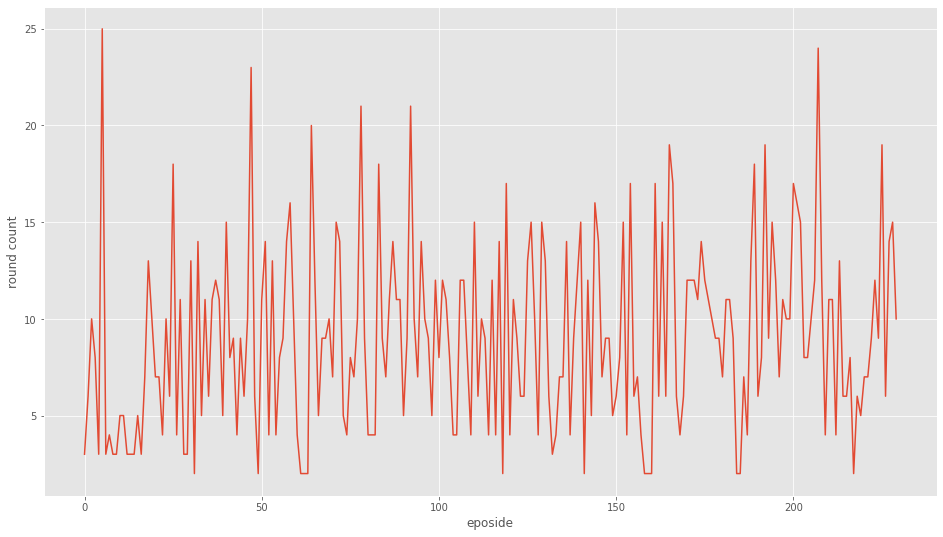

In [18]:
plt.figure(figsize = (16, 9))
x = range(data_group_sorted3["step_count"].values.shape[0])
y = data_group_sorted3["step_count"].values
plt.xlabel("eposide")
plt.ylabel("round count")
plt.plot(x, y)
plt.show()

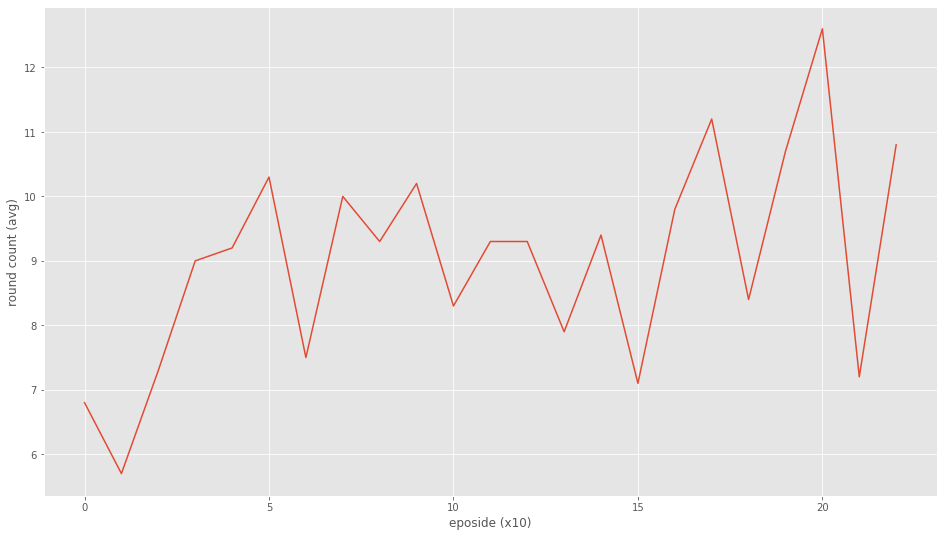

In [19]:
# 做一下平滑
avg_count_list = []
step_counts = data_group_sorted3["step_count"].values.tolist()
for i, val in enumerate(step_counts):
    if (i + 1) % 10 == 0:
        avg_val = np.mean(step_counts[(i + 1 - 10): (i + 1)])
        avg_count_list.append(avg_val)

plt.figure(figsize = (16, 9))
plt.xlabel("eposide (x10)")
plt.ylabel("round count (avg)")
plt.plot(range(len(avg_count_list)), avg_count_list)
plt.show()

In [20]:
data_group_sorted3["avg_chapture_reward"] = data_group_sorted3["chapture_reward"] / data_group_sorted3["step_count"]
data_group_sorted3

,match_id,re_reward,chapture_reward,step_count,match_id1,match_id2,avg_chapture_reward
0,26-0,-265.8000,-101.00,3,26,0,-33.666667
1,26-1,-282.6069,-106.29,6,26,1,-17.715000
2,26-2,-298.3249,-112.00,10,26,2,-11.200000
3,26-3,-286.9838,-106.58,8,26,3,-13.322500
4,26-4,-265.8000,-101.00,3,26,4,-33.666667
...,...,...,...,...,...,...,...
225,48-5,-332.6176,-120.16,19,48,5,-6.324211
226,48-6,-272.2200,-102.00,6,48,6,-17.000000
227,48-7,-311.2007,-113.87,14,48,7,-8.133571
228,48-8,-297.6369,-108.29,15,48,8,-7.219333


In [21]:
data_group_sorted3.to_excel(f"./outputs/hoho_avg-chapture-reward_{suffix}.xlsx")

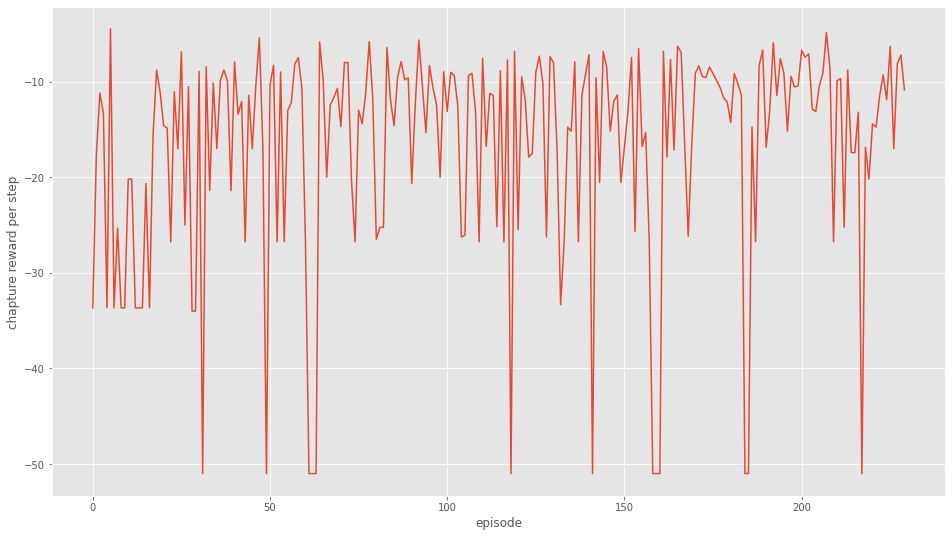

In [22]:
x = range(data_group_sorted3["avg_chapture_reward"].values.shape[0])
y = data_group_sorted3["avg_chapture_reward"].values
plt.figure(figsize = (16, 9))
plt.plot(x, y)
plt.xlabel("episode")
plt.ylabel("chapture reward per step")
plt.show()

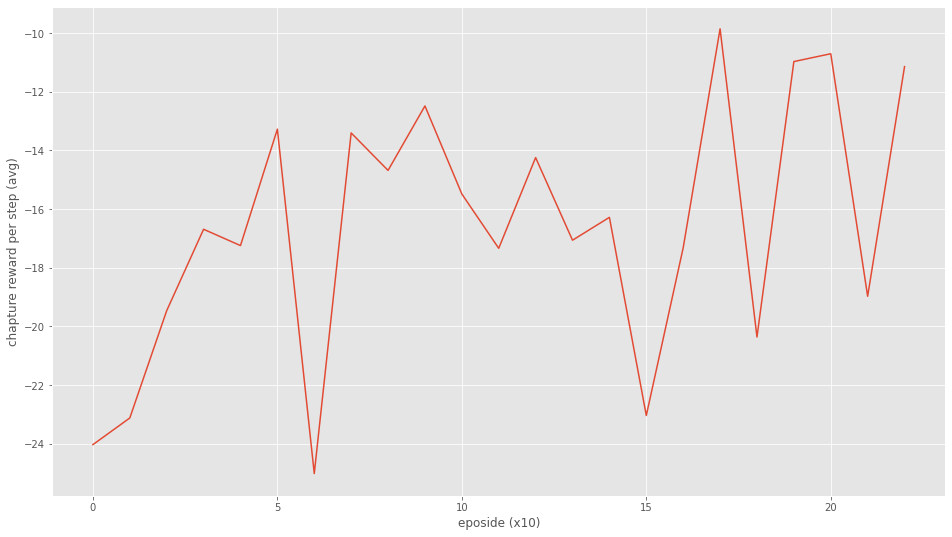

In [23]:
# 做一下平滑
avg_count_list = []
avg_crewards = data_group_sorted3["avg_chapture_reward"].values.tolist()
for i, val in enumerate(avg_crewards):
    if (i + 1) % 10 == 0:
        avg_val = np.mean(avg_crewards[(i + 1 - 10): (i + 1)])
        avg_count_list.append(avg_val)

plt.figure(figsize = (16, 9))
plt.xlabel("eposide (x10)")
plt.ylabel("chapture reward per step (avg)")
plt.plot(range(len(avg_count_list)), avg_count_list)
plt.show()

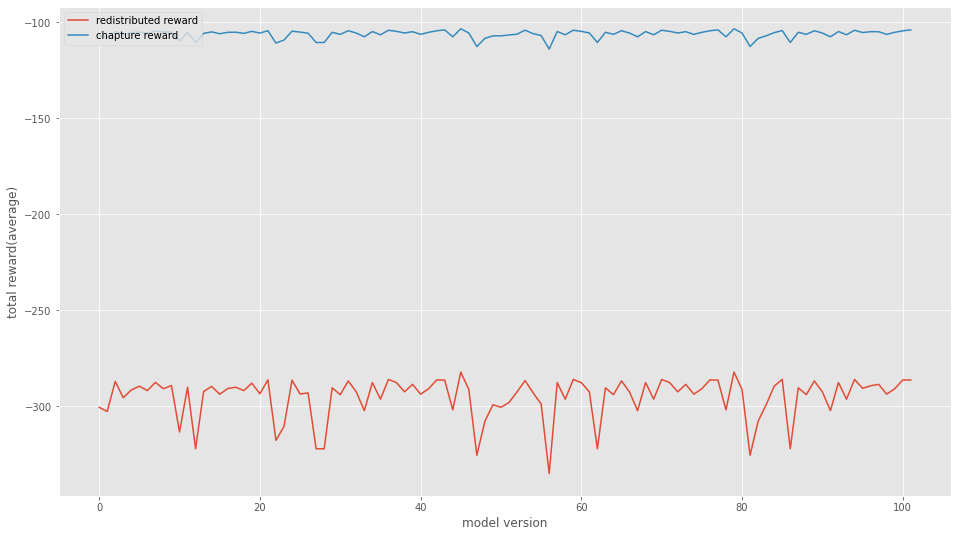

In [241]:
x = range(data_group_sorted4["model_version"].values.shape[0])
y1 = data_group_sorted4["average_re_reward"].values
y2 = data_group_sorted4["average_chapture_reward"].values
plt.figure(figsize = (16, 9))
plt.plot(x, y1, label = "redistributed reward")
plt.plot(x, y2, label = "chapture reward")
plt.legend(loc = "upper left")
plt.xlabel("model version")
plt.ylabel("total reward(average)")
plt.show()

In [255]:
data_chaptures = data[["match_id", "chaptures"]]

def chaptures_func(group_list):
    result = []
    for item in group_list:
        if len(item) > 0:
            single_chaptures = item.split(",")
            result.extend(single_chaptures)
    return ",".join(result)

data_chaptures_group = data_chaptures.groupby("match_id").agg({"chaptures": chaptures_func}).reset_index()
data_chaptures_group

,match_id,chaptures
0,0-0,"P,C,K"
1,0-1,"P,C,N,P,R,r,P,R,K"
2,0-10,"C,C,N,K"
3,0-2,"C,P,N,R,R,K,p"
4,0-3,"P,C,K"
...,...,...
787,99-1,"C,P,K"
788,99-2,"P,C,K"
789,99-3,"P,C,K"
790,99-4,"P,C,K"


In [261]:
data_chaptures_group["model_version"] = data_chaptures_group["match_id"].apply(lambda x: x.split("-")[0]).astype(int)
data_chaptures_group["match_index"] = data_chaptures_group["match_id"].apply(lambda x: x.split("-")[-1]).astype(int)
data_chaptures_group_sort = data_chaptures_group.groupby("model_version").apply(lambda x: x.sort_values(by = "match_index")).reset_index(drop = True)
data_chaptures_group_sort

,match_id,chaptures,model_version,match_idx,match_index
0,0-0,"P,C,K",0,0,0
1,0-1,"P,C,N,P,R,r,P,R,K",0,1,1
2,0-2,"C,P,N,R,R,K,p",0,2,2
3,0-3,"P,C,K",0,3,3
4,0-4,"P,P,p,R,C,A,B,R,C,N,B,p,A,K",0,4,4
...,...,...,...,...,...
787,101-2,"P,C,K",101,2,2
788,101-3,"P,C,K",101,3,3
789,101-4,"P,C,K",101,4,4
790,101-5,"P,C,K",101,5,5


In [265]:
counter_list = []
for i in range(len(data_chaptures_group_sort)):
    row = data_chaptures_group_sort.iloc[i]
    chapture_list = row["chaptures"].split(",")
    counter = Counter(chapture_list)
    counter_list.append(counter)

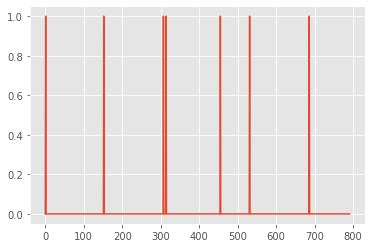

In [280]:
r_counter = [counter['r'] for counter in counter_list]
plt.plot(range(len(r_counter)), r_counter)

### 分配奖励到指定棋局(Double DQN Learning)

In [27]:
data_demo1 = data[data["match_id"] == "48-7"][["action", "done", "chaptures", "chapture_reward", "raw_reward", "re_reward"]].copy()
data_demo1

,action,done,chaptures,chapture_reward,raw_reward,re_reward
2034,b2d2,False,,0.00,0,-2.0449
2035,d2a2,False,,0.00,0,-2.9710
2036,a2a6,False,"C,p",-1.29,0,-3.8710
2037,h2d2,False,P,-1.00,0,-2.8000
2038,d2a2,False,P,-1.00,0,-5.3749
2039,c3c4,False,,0.00,0,-6.4810
2040,a2e2,False,R,-4.29,0,-6.6610
2041,c4c5,False,N,-2.00,0,-2.8000
2042,i0i1,False,,0.00,0,-1.0000
2043,c5d5,False,,0.00,0,-4.4749


In [28]:
data_demo1["raw_reward"] = [-1] * len(data_demo1)
data_demo1

,action,done,chaptures,chapture_reward,raw_reward,re_reward
2034,b2d2,False,,0.00,-1,-2.0449
2035,d2a2,False,,0.00,-1,-2.9710
2036,a2a6,False,"C,p",-1.29,-1,-3.8710
2037,h2d2,False,P,-1.00,-1,-2.8000
2038,d2a2,False,P,-1.00,-1,-5.3749
2039,c3c4,False,,0.00,-1,-6.4810
2040,a2e2,False,R,-4.29,-1,-6.6610
2041,c4c5,False,N,-2.00,-1,-2.8000
2042,i0i1,False,,0.00,-1,-1.0000
2043,c5d5,False,,0.00,-1,-4.4749


In [29]:
data_demo2 = data[data["match_id"] == "10-8"][["action", "done", "chaptures", "chapture_reward", "raw_reward", "re_reward"]].copy()
data_demo2["raw_reward"] = [-1] * len(data_demo2)
data_demo2

,action,done,chaptures,chapture_reward,raw_reward,re_reward


### 分配奖励到指定棋局(LSTM-Attention)

In [5]:
file_path = "./outputs/hoho_chess_data_20230905213354.xlsx"
chess_data = pd.read_excel(file_path)

In [6]:
contribution_file = "./outputs/hoho_action_contribution_maxstep15_win-lose-1_20230905213354.xlsx"
contribution_data = pd.read_excel(contribution_file)
contribution_data

,action_type,contribution
0,a0b0,0.065608
1,a0c0,0.061905
2,a0d0,0.000000
3,a0e0,0.000000
4,a0f0,0.000000
...,...,...
2081,e7c9,0.000000
2082,e7g5,0.000000
2083,g5e7,0.000000
2084,g9i7,0.000000


In [67]:
win = -1 # 赢为1，输为-1
hoho_match_data = chess_data[chess_data["match_id"] == "82-7"].copy()  # 随便选一场输的看看
actions_list = hoho_match_data["action"].values
hoho_match_contribution_data = contribution_data[contribution_data["action_type"].isin(actions_list)].copy()
total_contribution = hoho_match_contribution_data["contribution"].sum()
hoho_match_contribution_data["mine"] = hoho_match_contribution_data["contribution"].apply(lambda c: c / total_contribution * (len(hoho_match_contribution_data) * win))
hoho_match_contribution_data["alphago_zero"] = len(hoho_match_contribution_data) * [win]

In [68]:
hoho_match_contribution_data2 = hoho_match_contribution_data.rename(columns = {"action_type": "action"})

In [69]:
hoho_match_contribution_data2

,action,contribution,mine,alphago_zero
0,a0b0,0.065608,-1.088780,-1
8,a0a1,0.066551,-1.104414,-1
20,a1c1,0.065753,-1.091186,-1
204,b0a0,0.063889,-1.060244,-1
212,b0b1,0.055556,-0.921951,-1
223,b0c2,0.066449,-1.102728,-1
226,b1d1,0.044444,-0.737561,-1
253,b2b0,0.062500,-1.037195,-1
693,d1d3,0.044444,-0.737561,-1
904,e0f0,0.065432,-1.085853,-1


In [70]:
match_data_merge = pd.merge(hoho_match_data, hoho_match_contribution_data2, on = "action", how = "left")

In [71]:
match_data_merge

,match_id,round_id,state,action,next_state,done,chaptures,chapture_reward,win,converted,jid,contribution,mine,alphago_zero
0,82-7,16939208404300,RNBAKABNR/9/1C5C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5c...,b0c2,R1BAKABNR/9/1CN4C1/P1P1P1P1P/9/9/p1p1p1p1p/1c5...,0,NaN,0.00,0,0,82-7_16939208404300,0.066449,-1.102728,-1
1,82-7,16939208404301,R1BAKABNR/9/1CN4C1/P1P1P1P1P/9/9/p1p1p1p1p/1c2...,h2h8,R1BAKABNR/9/1CN6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4...,0,NaN,0.00,0,0,82-7_16939208404301,0.063492,-1.053659,-1
2,82-7,16939208404302,R1BAKABNR/9/1CN6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4...,b2b0,RCBAKABNR/9/2N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4/...,0,C,-25.41,0,0,82-7_16939208404302,0.062500,-1.037195,-1
3,82-7,16939208404303,RCBAKABNR/9/2N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4/...,c0a2,RC1AKABNR/9/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2c4...,0,NaN,0.00,0,0,82-7_16939208404303,0.066516,-1.103845,-1
4,82-7,16939208404304,RC1AKABNR/7r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/1c2...,a0a1,1C1AKABNR/R6r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/1c...,0,NaN,0.00,0,0,82-7_16939208404304,0.066551,-1.104414,-1
5,82-7,16939208404305,1C1AKABNR/Rc5r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p/4...,f0e1,1C1AK1BNR/Rc2A2r1/B1N6/P1P1P1P1P/9/9/p1p1p1p1p...,0,NaN,0.00,0,0,82-7_16939208404305,0.066664,-1.106300,-1
6,82-7,16939208404306,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P1P/9/9/p1p1p1p1p/...,i3i4,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,0,NaN,0.00,0,0,82-7_16939208404306,0.066502,-1.103602,-1
7,82-7,16939208404307,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,b0a0,C2AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/2...,0,NaN,0.00,0,0,82-7_16939208404307,0.063889,-1.060244,-1
8,82-7,16939208404308,C2AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/2...,a0b0,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,0,NaN,0.00,0,0,82-7_16939208404308,0.065608,-1.088780,-1
9,82-7,16939208404309,1C1AK1BNR/R3A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/...,b0b1,3AK1BNR/RC2A2r1/B1N6/PcP1P1P2/8P/9/p1p1p1p1p/2...,0,NaN,0.00,0,0,82-7_16939208404309,0.055556,-0.921951,-1


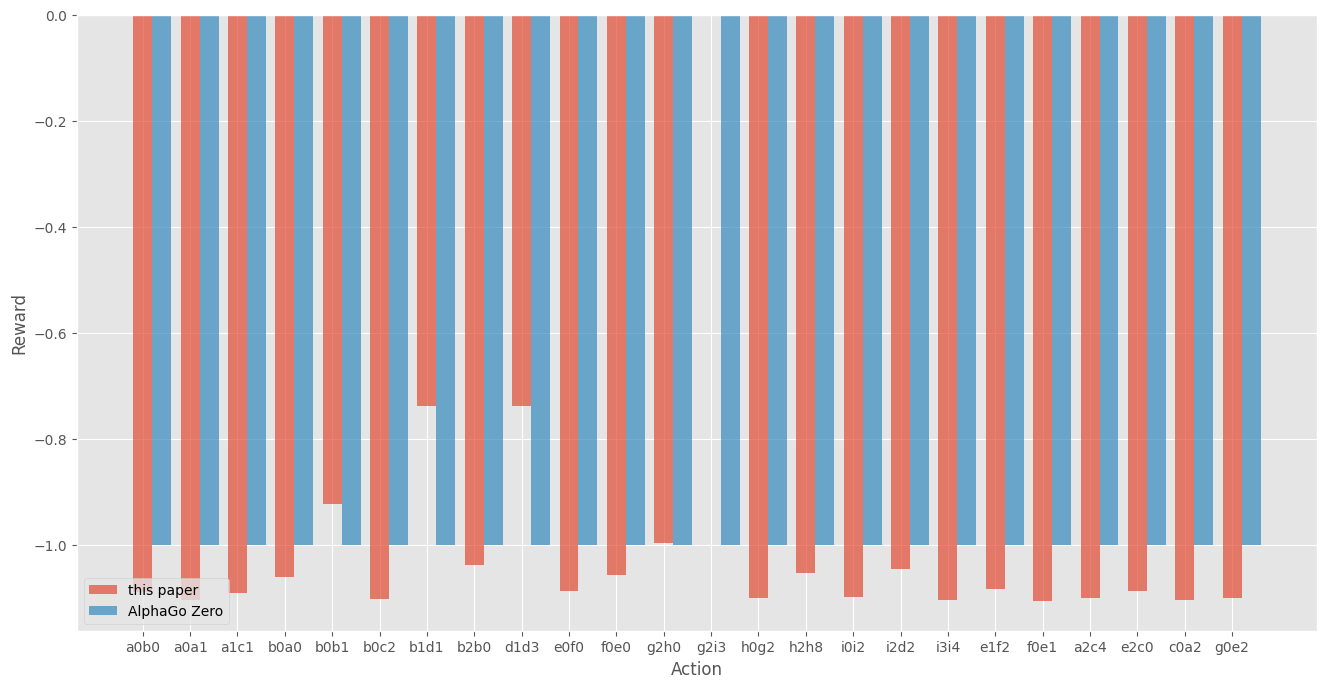

In [72]:
custom_ticks = list(range(len(hoho_match_contribution_data)))
custom_labels = hoho_match_contribution_data2["action"].values.tolist()
plt.figure(figsize = (16, 8))
plt.bar(range(len(hoho_match_contribution_data)), hoho_match_contribution_data["mine"], width=0.4, alpha=0.7, label='this paper' )
plt.bar([i + 0.4 for i in range(len(hoho_match_contribution_data))], hoho_match_contribution_data["alphago_zero"], width=0.4, alpha=0.7, label='AlphaGo Zero'  )
plt.xticks(custom_ticks, custom_labels)
plt.xlabel('Action')
plt.ylabel('Reward')
plt.legend(loc='lower left')
plt.show()